<a href="https://colab.research.google.com/github/KKarthik2002/es335-24-fall-assignment-2_Gamet/blob/master/ML_Assignment2_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import cv2
import os
from sklearn.kernel_approximation import RBFSampler
try:
  from einops import rearrange
except ModuleNotFoundError:
  %pip install einops
  from einops import rearrange

import warnings

# Remove warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if not os.path.exists('dog.jpg'):
   !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 709.4 kB/s eta 0:00:00
Device: cpu
--2024-09-20 07:02:58--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 54.230.18.129, 54.230.18.11, 54.230.18.18, ...
Connecting to segment-anything.com (segment-anything.com)|54.230.18.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.04s   

2024-09-20 07:02:59 (5.75 MB/s) - ‘dog.jpg’ saved [221810/221810]



Original Image Shape: torch.Size([3, 1365, 2048])


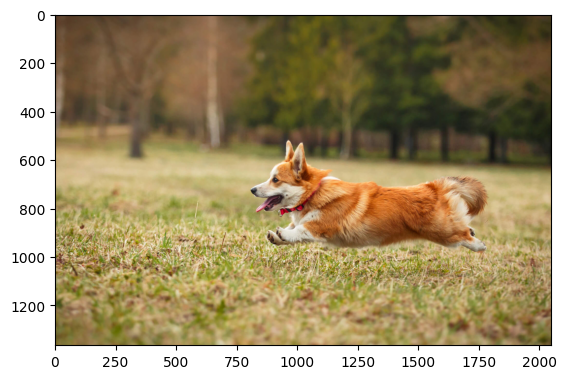

In [2]:
dog_img = torchvision.io.read_image('dog.jpg')
print(f"Original Image Shape: {dog_img.shape}")

plt.imshow(rearrange(dog_img, 'c h w -> h w c').numpy())
plt.show()

In [3]:
# Min-Max scaling
scaler_img = preprocessing.MinMaxScaler().fit(dog_img.reshape(-1, 1))
img_scaled = scaler_img.transform(dog_img.reshape(-1, 1)).reshape(dog_img.shape)
img_scaled = torch.tensor(img_scaled, dtype=torch.float32).to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

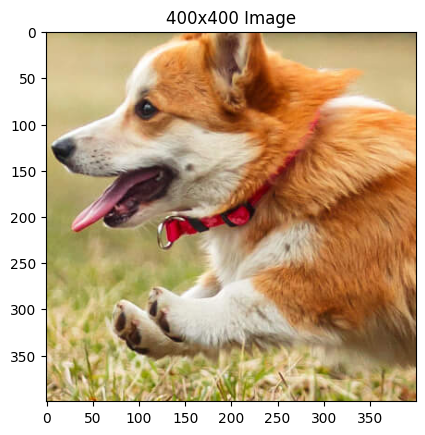

In [4]:
# Crop the image (400x400)
highResImg = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400).to(device)
plt.imshow(rearrange(highResImg, 'c h w -> h w c').cpu().numpy())
plt.title("400x400 Image")
plt.show()

In [5]:
# Resize to simulate low-resolution image (200x200)
crop_image_np = rearrange(highResImg, 'c h w -> h w c').cpu().numpy()
lowResImg = cv2.resize(crop_image_np, (200, 200), interpolation=cv2.INTER_AREA)
lowResImg = rearrange(lowResImg, 'h w c -> c h w')

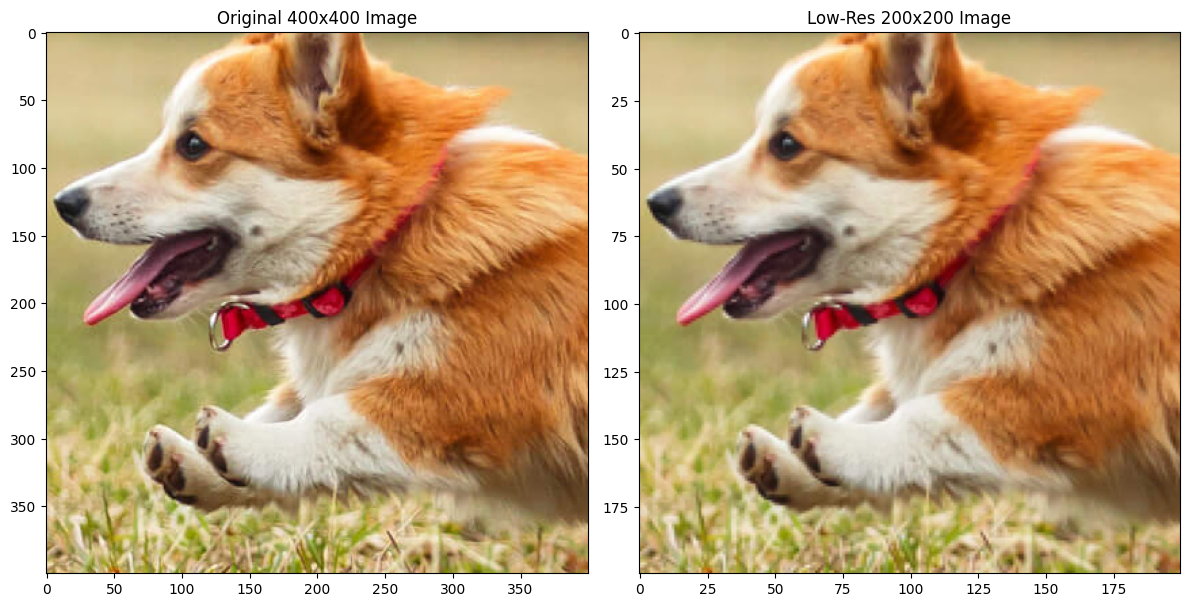

In [6]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Plot the original 400x400 image
ax0 = plt.subplot(gs[0])
ax0.imshow(rearrange(highResImg, 'c h w -> h w c').cpu().numpy())
ax0.set_title('Original 400x400 Image')

# Plot the low-res 200x200 image
ax1 = plt.subplot(gs[1])
ax1.imshow(rearrange(lowResImg, 'c h w -> h w c'))
ax1.set_title('Low-Res 200x200 Image')

plt.tight_layout()
plt.show()

In [7]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    height *= scale
    width *= scale

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [8]:

# Define Linear Model
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    print(f"Epoch {epochs} loss: {loss.item():.6f}")
    return loss.item()

In [9]:
def plot_original_vs_super_resolved_img(original_img, X_rff_super_resolved, net, scale = 2, output = 0):

    num_channels, height, width = original_img.shape

    height *= scale
    width *= scale

    with torch.no_grad():
        outputs = net(X_rff_super_resolved)
        super_r_img = outputs.reshape(height, width, num_channels).to(device)

    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height//scale}x{width//scale})')
    ax0.imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Enhanced Image ({height}x{width})')
    # The code was previously reshaping the image again. This is unnecessary since it was reshaped a few lines earlier
    ax1.imshow(super_r_img.cpu().detach().numpy())

    fig.suptitle('Original vs Enhanced Image',fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

    return super_r_img

In [10]:
import gc
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler


def enhance_image(lowResImg, num_features, sigma, lr, epochs, device = 'cpu'):

    X, Y = create_coordinate_map(lowResImg)
    Y = Y.to(device)

    scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X.cpu())
    scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)

    rff = RBFSampler(n_components=num_features, gamma=1/(2*sigma**2), random_state=42)
    X_rff = torch.tensor(rff.fit_transform(scaled_X.cpu().numpy())).float().to(device)

    net = LinearModel(X_rff.shape[1],lowResImg.shape[0]).to(device)
    train(net, lr, X_rff, Y, epochs)

    del X_rff, X, Y, scaled_X, scaler
    gc.collect()

    X_, Y_ = create_coordinate_map(lowResImg,scale=2)

    scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X_.cpu())
    scaled_X_ = torch.tensor(scaler.transform(X_.cpu())).float().to(device)

    X_rff = torch.tensor(rff.transform(scaled_X_.cpu().numpy())).float().to(device)
    print("\nComparison Between Low Resolution image and Enhanced image:")

    new_img = plot_original_vs_super_resolved_img(lowResImg, X_rff, net)
    del net, X_rff, X_, Y_, scaled_X_, scaler
    gc.collect()

    return new_img

Epoch 0 loss: 0.366960
Epoch 100 loss: 0.042887
Epoch 200 loss: 0.007970
Epoch 300 loss: 0.003575
Epoch 400 loss: 0.001950
Epoch 500 loss: 0.001095
Epoch 600 loss: 0.000620
Epoch 700 loss: 0.000350
Epoch 800 loss: 0.000195
Epoch 900 loss: 0.000106
Epoch 1000 loss: 0.000056
Epoch 1100 loss: 0.000028
Epoch 1200 loss: 0.000014
Epoch 1300 loss: 0.000007
Epoch 1400 loss: 0.000004
Epoch 1500 loss: 0.000003
Epoch 1600 loss: 0.000002
Epoch 1700 loss: 0.000002
Epoch 1800 loss: 0.000002
Epoch 1900 loss: 0.000002
Epoch 2000 loss: 0.000002

Comparison Between Low Resolution image and Enhanced image:


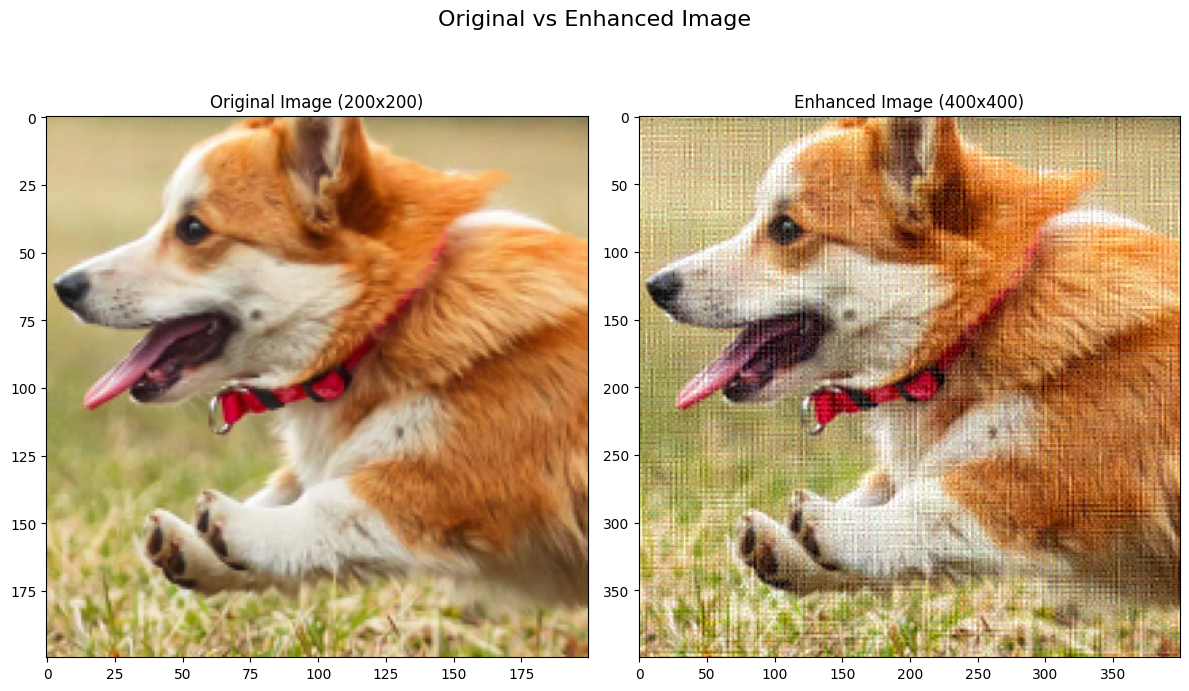

In [11]:
lowResImg = torch.tensor(lowResImg, dtype=torch.float32).to(device)
higResOutputImg = enhance_image(lowResImg,100000,sigma = 0.006, epochs=2000, lr=0.005)

Original highResImg vs Predicted highResImg


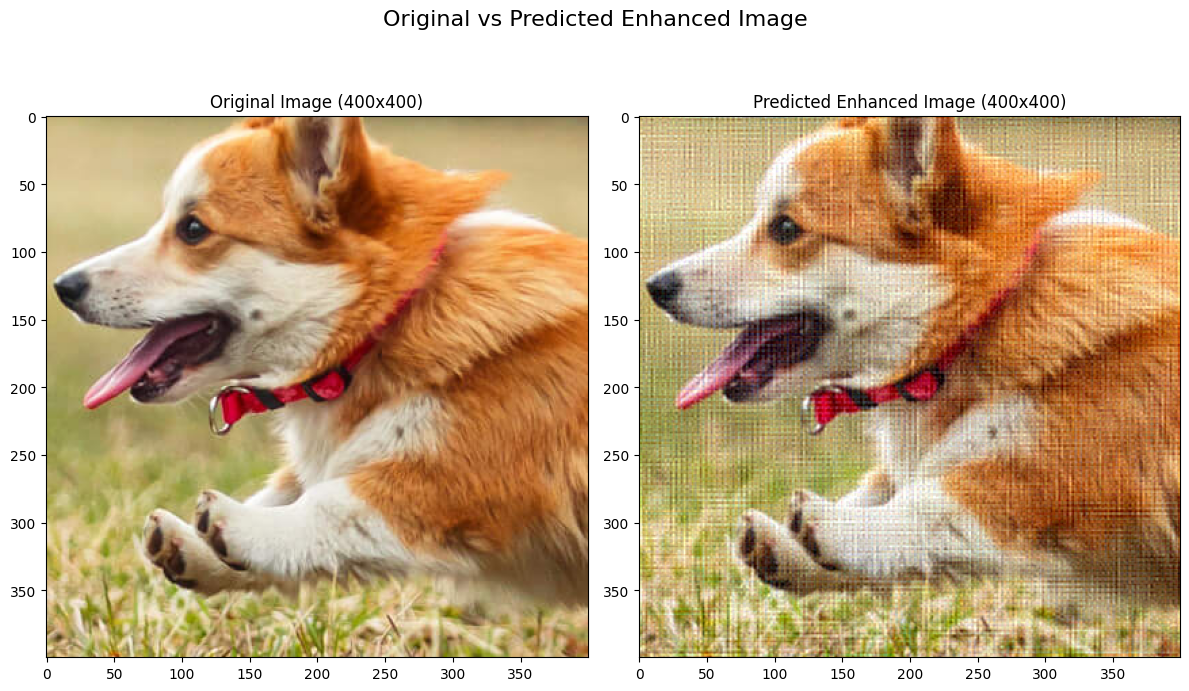

In [14]:
print("Original highResImg vs Predicted highResImg")
def plot_comparison(original_img, pred_img):
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    height, width = original_img.shape[1], original_img.shape[2]

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height}x{width})')
    ax0.imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Predicted Enhanced Image ({height}x{width})')
    ax1.imshow(pred_img.cpu().detach().numpy())

    fig.suptitle('Original vs Predicted Enhanced Image',fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

plot_comparison(highResImg, higResOutputImg)

In [12]:
# To determine rmse
def rmse(y_true, y_pred):
    # Ensure tensors have the same shape. Rearrange y_true if necessary
    if y_true.shape != y_pred.shape:
        y_pred = rearrange(y_pred, 'h w c-> c h w ')

    assert y_true.shape == y_pred.shape, "y and y_pred must have the same shape"

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

rmse(highResImg, higResOutputImg)

tensor(0.0689)

In [13]:
# To determine psnr
def psnr(y_true, y_pred):
  if y_true.shape != y_pred.shape:
        y_pred = rearrange(y_pred, 'h w c-> c h w ')

  assert y_true.shape == y_pred.shape, "Input shapes must match."

  y_true = y_true.flatten()
  y_pred = y_pred.flatten()
  mse = torch.mean((y_true - y_pred) ** 2)
  max_pixel = torch.max(y_true)
  return 20 * torch.log10(max_pixel / torch.sqrt(mse))

psnr(highResImg, higResOutputImg)

tensor(23.2369)